## EDA

In [121]:
# Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 

In [122]:
# Reading in dataset from webscraping:
climate = pd.read_csv('./data/cc_posts.csv')
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date
0,Hurricane Harvey survivors only now getting ba...,1,x2md4s,climatechange,https://www.beaumontenterprise.com/news/articl...,0,NaN,1.661974e+09,2022-08-31 19:30:28
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27


In [123]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10161 entries, 0 to 10160
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         10161 non-null  object 
 1   score         10161 non-null  int64  
 2   id            10161 non-null  object 
 3   subreddit     10161 non-null  object 
 4   url           10161 non-null  object 
 5   num_comments  10161 non-null  int64  
 6   body          4239 non-null   object 
 7   created       10161 non-null  float64
 8   date          10161 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 714.6+ KB


In [124]:
climate.fillna(0, inplace=True)
climate.isnull().sum()

title           0
score           0
id              0
subreddit       0
url             0
num_comments    0
body            0
created         0
date            0
dtype: int64

In [125]:
climate['num_comments'].describe()

count    10161.000000
mean        12.490306
std         20.334562
min          0.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        274.000000
Name: num_comments, dtype: float64

In [126]:
(climate['num_comments'] == 0).sum()

121

In [127]:
# Since the problem statement concerns submissions that have at least 1 comment -> removing any posts w/ 0:
climate = climate[climate['num_comments'] != 0]
climate.num_comments.median()

5.0

#### Baseline:
The **median** comment length is 5, so we are looking to see what words/features of a title can garner a post with 6 or more comments. 
As a note - I am getting the median *before* doing the train-test split to have a cohesive comparison metric between both sets. 

In [128]:
# Create a new column that is a binary target - whether a post has greater than the median (6 or more comments):
climate['abv_median'] = [1 if comment > 5 else 0 for comment in climate['num_comments']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1


In [129]:
climate['abv_median'].value_counts(normalize=True)

0    0.525199
1    0.474801
Name: abv_median, dtype: float64

#### Interpretation:
Our model has to predict better than just predicting the majority class - which is that a post has 5 or fewer comments (52.5% of posts).

In [130]:
# Getting the length of the title as a new column:
climate['title_len'] = [len(title) for title in climate['title']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69


In [131]:
# Getting the length of the body as a new column:
climate['body_len'] = [len(str(text)) for text in climate['body']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1


In [132]:
# Dropping 2 highest body length posts 33.5 k and 16.7k long -> next longest are 12k:
climate = climate[climate['body_len'] < 15000]

#### URL -> I want to be able to identify if the post is a link to an outside website or not.

In [133]:
# Splitting up the URL into a list of its components:
climate['url_split'] = climate['url'].str.split(pat=".")
climate['url_split'][:10]

1     [https://www, reddit, com/r/climatechange/comm...
2     [https://www, reddit, com/r/climatechange/comm...
3     [https://www, cnn, com/2022/08/30/weather/reco...
4     [https://www, reddit, com/r/climatechange/comm...
5     [https://www, reddit, com/r/climatechange/comm...
6     [https://www, reddit, com/r/climatechange/comm...
7     [https://www, reddit, com/r/climatechange/comm...
8     [https://themorningnews, com/news/2022/08/30/i...
9     [https://www, reddit, com/r/climatechange/comm...
10    [https://www, reddit, com/r/climatechange/comm...
Name: url_split, dtype: object

In [134]:
# Creating a new column that indicates if it is a reddit only post or external link:
reddit_terms = ['reddit', 'redd']

def check(urlList):
    flag = 1
    for chunk in reddit_terms:
        if chunk in urlList:
            flag = 0
    return flag

climate['external_link'] = climate.url_split.apply(lambda x: check(x))

In [135]:
climate['external_link'].value_counts(normalize=True)

0    0.50259
1    0.49741
Name: external_link, dtype: float64

In [136]:
# confirming mask worked for both urls that have 'reddit' and 'redd' in them:
climate[climate.id == 'vqqiv4']

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link
365,Debating climate change skeptic and he throws ...,116,vqqiv4,climatechange,https://i.redd.it/21vqzlh6hg991.jpg,250,0,1.656881e+09,2022-07-03 20:39:22,1,77,1,"[https://i, redd, it/21vqzlh6hg991, jpg]",0


### Visualizations:

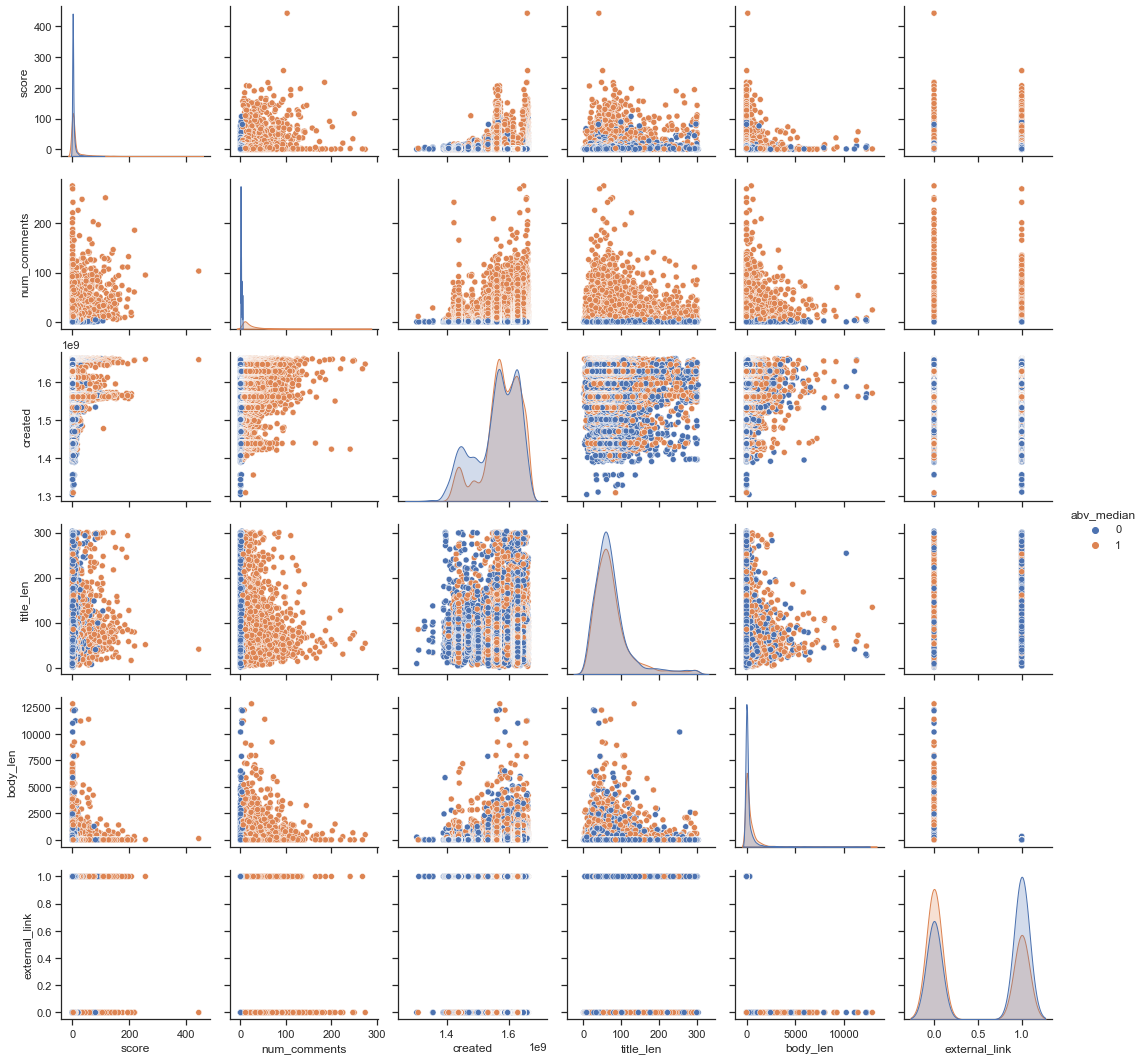

In [137]:
sns.set_theme(style="ticks")

sns.pairplot(climate, hue="abv_median");

#### Body Length:

In [140]:
# Taking a look at posts with longest body text:
climate.sort_values(by='body_len', ascending=False)[:5]

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link
5516,My Skeptic Grandfather sent me 29 points on wh...,1,dfz3l1,climatechange,https://www.reddit.com/r/climatechange/comment...,25,[https://docs.google.com/document/d/1viq9dyEH...,1.570719e+09,2019-10-10 14:49:48,1,134,12851,"[https://www, reddit, com/r/climatechange/comm...",0
5374,Climate Change and Veganism,10,d7egkd,climatechange,https://www.reddit.com/r/climatechange/comment...,3,"**Introduction**\n\nClimate change, despite st...",1.569092e+09,2019-09-21 18:46:55,0,27,12271,"[https://www, reddit, com/r/climatechange/comm...",0
4777,Movie review and commentary Planet of the Humans,1,g6agbq,climatechange,https://www.reddit.com/r/climatechange/comment...,9,I published this on Medium [Here](https://medi...,1.587593e+09,2020-04-22 22:02:49,1,48,12255,"[https://www, reddit, com/r/climatechange/comm...",0
6976,A Deep Dive into Solar Panels.,6,bvxsag,climatechange,https://www.reddit.com/r/climatechange/comment...,5,12.3 million. The number of homes solar panels...,1.559485e+09,2019-06-02 14:15:36,0,30,12194,"[https://www, reddit, com/r/climatechange/comm...",0
7312,"Debunking ""climate skeptics,"" part 1. There is...",57,c9peul,climatechange,https://www.reddit.com/r/climatechange/comment...,54,Hi guys! I'm thinking about making a series of...,1.562387e+09,2019-07-06 04:23:19,1,72,11394,"[https://www, reddit, com/r/climatechange/comm...",0


#### Number of comments:

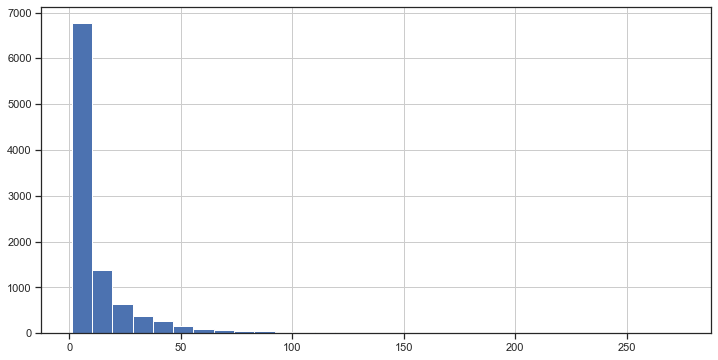

In [141]:
# Looking at distribution of number of comments:
climate['num_comments'].hist(figsize=(12,6), bins=30);

**Interpretation** - very right skewed. I'll explore outliers, but I don't necessarily want to remove them if they are valid because the most highly commented posts could be have very relevant information in them as to what makes a post popular.

In [142]:
climate['num_comments'].describe()

count    10038.000000
mean        12.640167
std         20.411055
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        274.000000
Name: num_comments, dtype: float64

In [143]:
# This is an example of what trimming the upper range of comments could look like, but I won't do that yet.
climate['num_comments'].mean() + (climate['num_comments'].std() * 3)

73.87333243166194

In [144]:
# Looking at text for most commented on posts:
# climate.sort_values(by='num_comments', ascending=False)[:10]
climate['num_comments'].sort_values(ascending=False)

841     274
1505    268
365     250
468     247
9634    241
       ... 
8101      1
8104      1
2709      1
3858      1
2136      1
Name: num_comments, Length: 10038, dtype: int64

#### Title length

In [145]:
# Looking at shortest titles: 
climate.sort_values(by='title_len')[:10]

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link
4014,y,2,d9l5xl,climatechange,https://i.redd.it/rt8tuscdiyo31.png,1,0,1.569512e+09,2019-09-26 15:27:38,0,1,1,"[https://i, redd, it/rt8tuscdiyo31, png]",0
128,GBR,4,wm5bga,climatechange,https://www.reddit.com/r/climatechange/comment...,9,I've argued here at times about the reported n...,1.660260e+09,2022-08-11 23:15:55,1,3,631,"[https://www, reddit, com/r/climatechange/comm...",0
4797,Hi!,1,g4jla2,climatechange,https://www.reddit.com/r/climatechange/comment...,6,I’m making a list on what climate change will ...,1.587346e+09,2020-04-20 01:22:18,1,3,177,"[https://www, reddit, com/r/climatechange/comm...",0
2608,Hmmm,1,o34mxf,climatechange,https://i.redd.it/eosvjziwe4671.jpg,1,0,1.624064e+09,2021-06-19 00:55:12,0,4,1,"[https://i, redd, it/eosvjziwe4671, jpg]",0
5577,hmmm,5,dytujx,climatechange,https://i.redd.it/b900h0k5mqz31.jpg,2,0,1.574210e+09,2019-11-20 00:39:35,0,4,1,"[https://i, redd, it/b900h0k5mqz31, jpg]",0
4574,Sad.,1,f16juw,climatechange,https://i.redd.it/0m72csfacvf41.jpg,7,0,1.581241e+09,2020-02-09 09:39:26,1,4,1,"[https://i, redd, it/0m72csfacvf41, jpg]",0
6762,Fear,1,bmbvp7,climatechange,https://www.reddit.com/r/climatechange/comment...,10,Climate Change is something that terrifies me ...,1.557355e+09,2019-05-08 22:34:16,1,4,2635,"[https://www, reddit, com/r/climatechange/comm...",0
6502,Kids,1,aofvsv,climatechange,https://www.reddit.com/r/climatechange/comment...,10,Should I have kids? I know every new person co...,1.549628e+09,2019-02-08 12:05:19,1,4,714,"[https://www, reddit, com/r/climatechange/comm...",0
8268,PETM,0,99dacy,climatechange,https://www.reddit.com/r/climatechange/comment...,2,I’ve seen it suggests that the global temperat...,1.534944e+09,2018-08-22 13:22:09,0,4,172,"[https://www, reddit, com/r/climatechange/comm...",0
4031,halp,0,d9bru6,climatechange,https://i.redd.it/99twh0k9yto31.png,3,0,1.569456e+09,2019-09-26 00:07:34,0,4,1,"[https://i, redd, it/99twh0k9yto31, png]",0


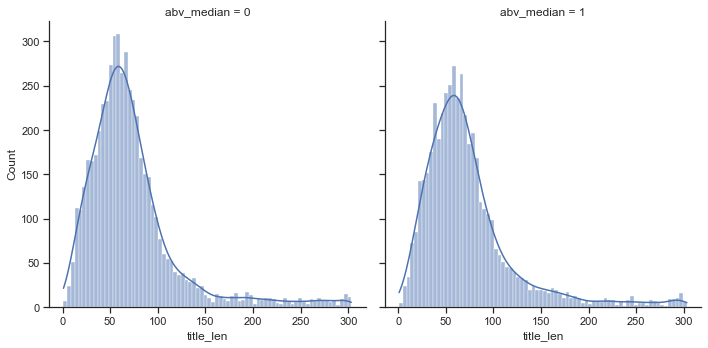

In [146]:
# Title length by whether above or below median:
sns.displot(data=climate, x="title_len", kde=True, col='abv_median');

In [147]:
# Going to remove highest len titles since also right skewed:

climate = climate[climate['title_len'] < 200]

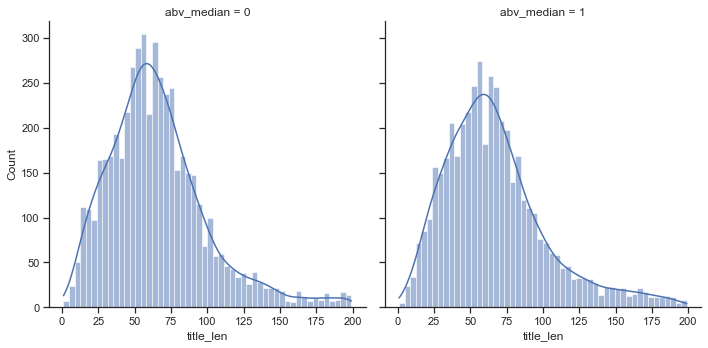

In [148]:
sns.displot(data=climate, x="title_len", kde=True, col='abv_median');

In [149]:
# Checking that that did not remove too many submissions:
climate.shape

(9659, 14)

#### Score:

In [150]:
climate.sort_values(by='score', ascending=False)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link
235,They knew. They knew a hundred years ago.,443,w83diw,climatechange,https://www.reddit.com/r/climatechange/comment...,103,&#x200B;\n\nhttps://preview.redd.it/frjvd68frs...,1.658791e+09,2022-07-25 23:14:53,1,41,126,"[https://www, reddit, com/r/climatechange/comm...",0
161,We Are Not Freaking Out Enough About Climate C...,256,wim5qb,climatechange,https://gizmodo.com/we-are-unprepared-for-wors...,95,Yeah... It's all fine. 🫣,1.659896e+09,2022-08-07 18:15:00,1,51,24,"[https://gizmodo, com/we-are-unprepared-for-wo...",1
313,Is the European heat wave due to climate change?,218,w1csv9,climatechange,https://www.reddit.com/r/climatechange/comment...,185,0,1.658080e+09,2022-07-17 17:39:18,1,48,1,"[https://www, reddit, com/r/climatechange/comm...",0
379,US Supreme Court just curbed the authority of ...,217,vobiat,climatechange,https://www.reddit.com/r/climatechange/comment...,61,"If it’s not one thing it’s another, right?\n\n...",1.656604e+09,2022-06-30 15:45:50,1,79,329,"[https://www, reddit, com/r/climatechange/comm...",0
4010,Costa Rica will run on more than 98% renewable...,207,d9qnzp,climatechange,https://ticotimes.net/2019/09/24/costa-rica-wi...,14,0,1.569535e+09,2019-09-26 21:57:45,1,80,1,"[https://ticotimes, net/2019/09/24/costa-rica-...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,New book: Doubt and Certainty in Climate Science,0,3lr567,climatechange,http://judithcurry.com/2015/09/20/new-book-dou...,6,0,1.442802e+09,2015-09-21 02:22:26,1,48,1,"[http://judithcurry, com/2015/09/20/new-book-d...",1
6425,What if...,0,av3ttg,climatechange,https://www.reddit.com/r/climatechange/comment...,1,What if we paint the roads lighter so some lig...,1.551211e+09,2019-02-26 20:01:50,0,10,86,"[https://www, reddit, com/r/climatechange/comm...",0
8950,Hiatus revisionism,0,3lgfl5,climatechange,http://judithcurry.com/2015/09/17/hiatus-revis...,8,0,1.442597e+09,2015-09-18 17:23:28,1,18,1,"[http://judithcurry, com/2015/09/17/hiatus-rev...",1
8952,"Debunking the climate hiatus (Climatic Change,...",0,3lfdig,climatechange,http://link.springer.com/article/10.1007%2Fs10...,52,0,1.442581e+09,2015-09-18 12:50:53,1,66,1,"[http://link, springer, com/article/10, 1007%2...",1


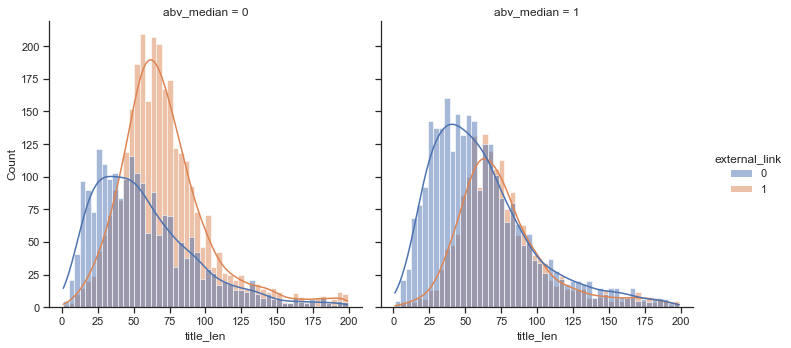

In [156]:
sns.displot(data=climate, x="title_len", kde=True, col="abv_median", hue='external_link');

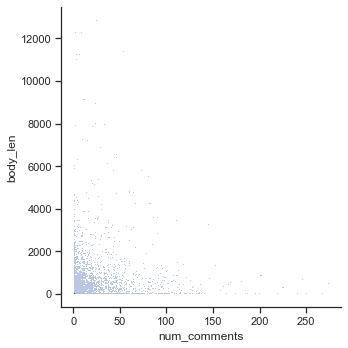

In [157]:
sns.displot(climate, x='num_comments', y='body_len');

## Cleaning the text in 'title' data:
1) Normalization
2) Stop words
3) Stemming
4) Lemmatization
5) Part of Speech (POS) tagging and chunking

(inspiration from [this blog post](https://medium.com/towards-data-science/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7))

### 1. Normalization:

Remove the 'noise'(non alpha-numeric characters) and lowercase words:

In [93]:
# References from documentation: https://docs.python.org/3/howto/regex.html

def  clean_text(df, text_field, new_text_field_name):
    # lowercase text
    df[new_text_field_name] = df[text_field].str.lower()
    # remove any non alpha-numeric characters
    # df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", elem))  
    # remove numbers
    # df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(climate, 'title', 'title_clean')

In [94]:
# Checking to see what cleaned titles look like:
data_clean['title_clean'].iloc[:5]

1    in what condition would the atmosphere have to...
2    has anyone here been personally affected by a ...
3    a prolonged and record heat wave builds over t...
4    graph that illustrates changes in major weathe...
5    started a geology class  teacher denies global...
Name: title_clean, dtype: object

#### Tokenize:

In [95]:
data_clean['title_tokens'] = data_clean['title_clean'].apply(lambda x: word_tokenize(x))
data_clean.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link,title_clean,title_tokens
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,"[https://www, reddit, com/r/climatechange/comm...",0,in what condition would the atmosphere have to...,"[in, what, condition, would, the, atmosphere, ..."
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,"[https://www, reddit, com/r/climatechange/comm...",0,has anyone here been personally affected by a ...,"[has, anyone, here, been, personally, affected..."
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,"[https://www, cnn, com/2022/08/30/weather/reco...",1,a prolonged and record heat wave builds over t...,"[a, prolonged, and, record, heat, wave, builds..."


In [98]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text
data_clean['title_tokens_stem'] = data_clean['title_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link,title_clean,title_tokens,title_tokens_stem
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,"[https://www, reddit, com/r/climatechange/comm...",0,in what condition would the atmosphere have to...,"[in, what, condition, would, the, atmosphere, ...","[in, what, condit, would, the, atmospher, have..."
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,"[https://www, reddit, com/r/climatechange/comm...",0,has anyone here been personally affected by a ...,"[has, anyone, here, been, personally, affected...","[ha, anyon, here, been, person, affect, by, a,..."
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,"[https://www, cnn, com/2022/08/30/weather/reco...",1,a prolonged and record heat wave builds over t...,"[a, prolonged, and, record, heat, wave, builds...","[a, prolong, and, record, heat, wave, build, o..."


In [100]:
data_clean['stem_string'] = [' '.join(i) for i in data_clean['title_tokens_stem']]
data_clean.head()

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link,title_clean,title_tokens,title_tokens_stem,stem_string
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,"[https://www, reddit, com/r/climatechange/comm...",0,in what condition would the atmosphere have to...,"[in, what, condition, would, the, atmosphere, ...","[in, what, condit, would, the, atmospher, have...",in what condit would the atmospher have to be ...
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,"[https://www, reddit, com/r/climatechange/comm...",0,has anyone here been personally affected by a ...,"[has, anyone, here, been, personally, affected...","[ha, anyon, here, been, person, affect, by, a,...",ha anyon here been person affect by a major cl...
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,"[https://www, cnn, com/2022/08/30/weather/reco...",1,a prolonged and record heat wave builds over t...,"[a, prolonged, and, record, heat, wave, builds...","[a, prolong, and, record, heat, wave, build, o...",a prolong and record heat wave build over the ...
4,Graph that illustrates changes in major weathe...,6,x1v5ru,climatechange,https://www.reddit.com/r/climatechange/comment...,5,I’m looking for a graph that depicts the shift...,1.661895e+09,2022-08-30 21:32:19,0,89,196,"[https://www, reddit, com/r/climatechange/comm...",0,graph that illustrates changes in major weathe...,"[graph, that, illustrates, changes, in, major,...","[graph, that, illustr, chang, in, major, weath...",graph that illustr chang in major weather even...
5,Started a geology class - teacher denies globa...,73,x1poql,climatechange,https://www.reddit.com/r/climatechange/comment...,82,I'm in a 100 level course for geology with a t...,1.661882e+09,2022-08-30 17:53:50,1,56,4221,"[https://www, reddit, com/r/climatechange/comm...",0,started a geology class teacher denies global...,"[started, a, geology, class, teacher, denies, ...","[start, a, geolog, class, teacher, deni, globa...",start a geolog class teacher deni global warm


In [101]:
climate.columns

Index(['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body',
       'created', 'date', 'abv_median', 'title_len', 'body_len', 'url_split',
       'external_link', 'title_clean', 'title_tokens', 'title_tokens_stem',
       'stem_string'],
      dtype='object')

In [102]:
# Dropping unnecessary columns:
climate.drop(columns=['url_split', 'id', 'title_tokens', 'title_tokens_stem'], inplace=True)

In [103]:
data_clean.to_csv('cleaned_data.csv', header=True, index=False, columns=list(data_clean.axes[1]))